In [1]:
import pandas as pd
import numpy as np
import math
import re
import random
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Bidirectional
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Soft Computing/Project/updated_dataset.csv')

In [4]:
df.head()

,Unnamed: 0,review,sentiment,target,length
0,4320,film one boring film ever made. thing liked us...,negative,0,591
1,19407,got action fantasy mixed together want action ...,positive,1,189
2,14362,"1955 heist film follows tony le stephanois, re...",positive,1,938
3,5596,one film couple hour sunday morning -- able th...,negative,0,1100
4,14179,im big tim matheson fan admit liked film.it da...,positive,1,565


## Vectorization

In [6]:
dataset = df
unique_label = np.unique(df["target"])
num_classes = len(unique_label)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['review'].values, pd.get_dummies(dataset['target']).values, test_size=0.50)

MAX_NB_WORDS = 120811
MAX_SEQUENCE_LENGTH = 2000
EMBEDDING_DIM = 250

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
word_index = tokenizer.word_index
print("found ", len(word_index), " unique tokens")

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(train_seq, maxlen=MAX_SEQUENCE_LENGTH)
pad_test = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', pad_train.shape)

print(pad_train.shape,y_train.shape)
print(pad_test.shape,y_test.shape)

found  120811  unique tokens
Shape of data tensor: (25000, 2000)
(25000, 2000) (25000, 2)
(25000, 2000) (25000, 2)


## Model

In [7]:
model_1 = Sequential()
model_1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=pad_train.shape[1]))
model_1.add(LSTM(250, activation= 'tanh', return_sequences=True))
model_1.add(Dropout(0.5))
model_1.add(LSTM(150, activation= 'tanh', return_sequences=True))
model_1.add(Dropout(0.5))
model_1.add(LSTM(100, activation= 'tanh'))
model_1.add(Dropout(0.5))
model_1.add(Dense(2, activation='sigmoid'))


model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model_1.summary()

epochs = 20
batch_size = 128

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 250)         30202750  
_________________________________________________________________
lstm (LSTM)                  (None, 2000, 250)         501000    
_________________________________________________________________
dropout (Dropout)            (None, 2000, 250)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2000, 150)         240600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 150)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0

In [8]:
history = model_1.fit(pad_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/20
176/176 [==============================] - 313s 2s/step - loss: 0.4461 - accuracy: 0.7963 - val_loss: 0.3351 - val_accuracy: 0.8572
Epoch 2/20
176/176 [==============================] - 302s 2s/step - loss: 0.1846 - accuracy: 0.9340 - val_loss: 0.3529 - val_accuracy: 0.8592
Epoch 3/20
176/176 [==============================] - 301s 2s/step - loss: 0.0766 - accuracy: 0.9756 - val_loss: 0.4901 - val_accuracy: 0.8616
Epoch 4/20
176/176 [==============================] - 302s 2s/step - loss: 0.0358 - accuracy: 0.9897 - val_loss: 0.4788 - val_accuracy: 0.8520
Epoch 5/20
176/176 [==============================] - 301s 2s/step - loss: 0.0217 - accuracy: 0.9940 - val_loss: 0.6405 - val_accuracy: 0.8516
Epoch 6/20
176/176 [==============================] - 301s 2s/step - loss: 0.0161 - accuracy: 0.9952 - val_loss: 0.8357 - val_accuracy: 0.8440
Epoch 7/20
176/176 [==============================] - 301s 2s/step - loss: 0.0269 - accuracy: 0.9912 - val_loss: 0.6333 - val_accuracy: 0.8472

In [10]:
evaluation = model_1.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
print("Accuracy is : ", accuracy)

782/782 [==============================] - 269s 344ms/step - loss: 1.0043 - accuracy: 0.8554
Accuracy is :  85.54400205612183


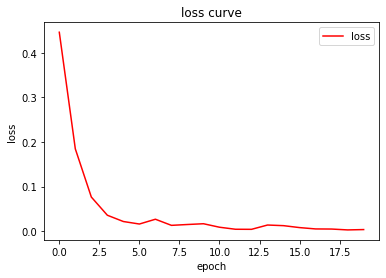

In [12]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], color='r')
# pyplot.plot(history.history['val_loss'], color='b')
pyplot.title('loss curve')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'val_loss'], loc='upper right')
pyplot.show()

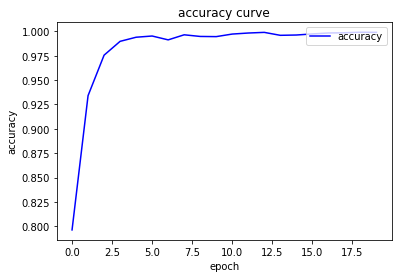

In [13]:
from matplotlib import pyplot

pyplot.plot(history.history['accuracy'], color='b')
# pyplot.plot(history.history['val_accuracy'], color='b')
pyplot.title('accuracy curve')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['accuracy', 'val_accuracy'], loc='upper right')
pyplot.show()

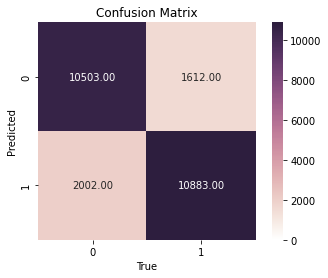

In [15]:
y_pred = model_1.predict(pad_test)

new_y_pred = np.argmax(y_pred, axis=1)
new_y_test = np.argmax(y_test, axis=1)

conf_arr = np.zeros((num_classes, num_classes))

for i in range(len(new_y_pred)):
        conf_arr[new_y_pred[i]][new_y_test[i]] += 1

df_cm = pd.DataFrame(conf_arr, index = unique_label, columns = unique_label)


fig = plt.figure()
plt.clf()

ax = fig.add_subplot()
ax.set_aspect(1)

cmap = sb.cubehelix_palette(light=1, as_cmap=True)
res = sb.heatmap(df_cm, annot=True, vmin=0.0, vmax=np.max(conf_arr), fmt='.2f', cmap=cmap)

plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

In [ ]:
precision =   precision_score(new_y_test, new_y_pred) * 100
recall =  recall_score(new_y_test, new_y_pred) * 100
f1_score =  f1_score(new_y_test, new_y_pred) * 100
print(precision)
print(f1_score)
print(recall)

99.34640522875817
98.80823401950163
98.27586206896551


In [16]:
print(classification_report(new_y_test, new_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85     12505
           1       0.84      0.87      0.86     12495

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision =   precision_score(new_y_test, new_y_pred) * 100
recall =  recall_score(new_y_test, new_y_pred) * 100
f1_score =  f1_score(new_y_test, new_y_pred) * 100
print('Pricision = ',precision)
print('F1_score = ',f1_score)
print('Recall = ',recall)

Pricision =  84.46255335661623
F1_score =  85.76044129235618
Recall =  87.09883953581432


In [19]:
model_1.save('/content/drive/MyDrive/Soft Computing/Project/saved_info/LSTM/v1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Soft Computing/Project/saved_info/LSTM/v1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Soft Computing/Project/saved_info/LSTM/v1/assets


In [21]:
import keras
loaded_model = keras.models.load_model('/content/drive/MyDrive/Soft Computing/Project/saved_info/LSTM/v1')

In [22]:
evaluation = loaded_model.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
print("Accuracy is : ", accuracy)

782/782 [==============================] - 274s 348ms/step - loss: 1.0043 - accuracy: 0.8554
Accuracy is :  85.54400205612183


In [23]:
np.save('/content/drive/MyDrive/Soft Computing/Project/saved_info/LSTM/v1/history.npy',history.history)

In [24]:
h=np.load('/content/drive/MyDrive/Soft Computing/Project/saved_info/LSTM/v1/history.npy',allow_pickle='TRUE').item()

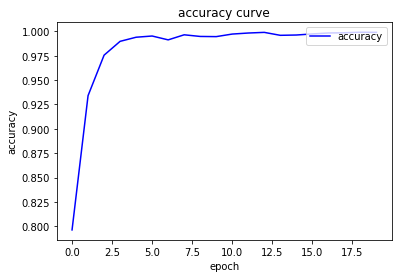

In [25]:
from matplotlib import pyplot

pyplot.plot(h['accuracy'], color='b')
# pyplot.plot(history.history['val_accuracy'], color='b')
pyplot.title('accuracy curve')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['accuracy', 'val_accuracy'], loc='upper right')
pyplot.show()